# **Portfolio Project:** LDA Topic Modeling & VADER Sentiment Analysis for Political News Articles on Events related to Nigeria in 2019

---

### The following portfolio project demonstrates a portion of my skills in Natural Language Processing relating to topic modeling and sentiment analysis

---

In [1]:
import pandas as pd

df = pd.read_csv("newsfeed.csv")

In [2]:
df.shape

(24394, 2)

In [3]:
df.columns

Index(['week', 'text'], dtype='object')

---
---

### I originally converted a date column for the news article dataset into the week number in the year 2019 using Excel's WEEKNUM function.

### I now will create a column with the label of what quarter of the year each news article was written in, as I intend to later compare sentiment analysis scores by quarter of the year.  The weeks of the year correspond to the following quarters:

- Q1 (Weeks 1 - 13)
- Q2 (Weeks 14 - 26)
- Q3 (Weeks 27 - 39)
- Q4 (Weeks 40 - 53)

### I do so using the following function:

---
---

In [4]:
def quarters(x):
    if x <= 13:
        return 1
    elif x <= 26:
        return 2
    elif x <= 39:
        return 3
    else:
        return 4


In [5]:
df['quarter'] = df['week'].apply(quarters)

In [6]:
df.columns

Index(['week', 'text', 'quarter'], dtype='object')

In [7]:
df_q1 = df.loc[(df['quarter']==1)].copy()

In [8]:
df_q2 = df.loc[(df['quarter']==2)].copy()

In [9]:
df_q3 = df.loc[(df['quarter']==3)].copy()

In [10]:
df_q4 = df.loc[(df['quarter']==4)].copy()

In [11]:
news = df['text'].copy()

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rsb84\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### The following function removes all brackets, numbers, and special characters using regex, lowercases any non-lowercase words, removes NLTK stopwords as well as any additional stopwords I specify, and stems and tokenizes each word:

In [13]:
def clean_text_tokenize(text_in):
    import re
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    sw = stopwords.words('english')
    sw = set(sw)
    new_sw = {"said", "says", "saying", "say", "us", "since", "like", "likes", "people"}
    sw = sw.union(new_sw)
    no_brackets = re.sub(r"[\([{})\]]", "", text_in)
    clean_text = re.sub('[^A-z]+', " ", no_brackets).lower().split()
    clean_text = [word for word in clean_text if word not in sw]
    clean_text = [ps.stem(word) for word in clean_text]
    return clean_text

In [14]:
df['text_lda_tokenized']=df.text.apply(clean_text_tokenize)

In [15]:
df['text_lda_tokenized'].shape

(24394,)


---
---

## **Latent Dirichlet Allocation (LDA) Topic Modeling Section:**



## **An Explanation of LDA:**

### LDA is a statistical approach which assumes that documents are combinations of topics, and topics are combinations of words. It seeks to uncover latent topics based on a user’s input of the total number of topics among corpuses. The algorithm iterates through the words in each document, initially randomly distributing the words among the topics. LDA assumes that for each word in a given document that is at the time being considered, its assigned topic is incorrect, while also assuming all other words are correctly assigned to their current topics. Words are then optimally reassigned to the various topics probabilistically, given the percentage of words within that document which are grouped with a given topic, and the number times the word being considered has been grouped with a given topic, across all documents.

### LDA converts a preprocessed document-word matrix (derived from corpuses) into both an optimally determined document-topic matrix and an optimally determined topic-word matrix. The values of the document-topic matrix are the likelihoods that the document in a given row contains the topic in a given column. On the other hand, the values of the topic-word matrix are the likelihoods that the topic in a given row contains the word in a given column.

---

---

## **Choosing the Optimal Number of Topics:**

### One weakeness of LDA is that it let's users decide and specify the optimal number of topics. To overcome this, I first will use a coding technique which assumes  the optimal number of topics is that which results in those topics which are chosen containing words that are most similar to each other within each topic, while simultaneously resulting in minimal similarity of words between the topics. This technique is described in detail at: https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin 

### Firstly, to find topics which internally contain words most similar to each other, I sought to find the topic number in which a higher genism “topic coherence” score was found. The coherence score assesses the degree of semantic similarity between those words that rank highly within topics found by LDA, and is based on code which “combines the indirect cosine measure with the NPMI and the boolean sliding window” (Röder et al., 2015).

### Secondly, to find the number of topics where the similarity/overlap of topics between each other was minimized, I sought to iteratively find the topic number whereby the mean Jaccard similarity between topics was minimized. The Jaccard distance formula was used whereby the intersection between the words of two topics is divided by the union of the words of two topics, and the mean of the Jaccard similarities among all topics for a given topic number currently under consideration was calculated. This mean is termed the “mean stabilities” or “average topic overlap” score. A range of possible optimal topic numbers to evaluate is specified in the code below. 

### The ideal topic number is found where the maximum distance is located between the "topic coherence score" and "average topic overlap"; however, if there is more than one point at which this distance is maximized, the smallest topic number among these multiple maximum distance points is chosen.

---

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gensim
from gensim.models import CoherenceModel, LdaModel
from gensim import corpora
import gensim.corpora as corpora

In [20]:
dirichlet_dict = corpora.Dictionary(df.text_lda_tokenized)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in df.text_lda_tokenized]

In [21]:
# Considering 1-20 topics:
num_topics = list(range(21)[1:])
num_keywords = 10

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=15,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [22]:
def jaccard_similarity(topic_1, topic_2):
    """
    This function derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A measurement used for determining the level of similarity or diverence between two sets, e.g., text documents
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - The lower the Jaccard Similarity score the better as a lower score means less topic overlap. 
       A score of 0 means two sets share nothing in common, while a score of 1 means they are identical.
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [23]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]):
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]):
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [24]:
coherences = [CoherenceModel(model=LDA_models[i], texts=df.text_lda_tokenized, dictionary=dirichlet_dict, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [25]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # This limits topic numbers to the prespecified number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # This chooses the lower topic number in case there are more than one maximum distances between the "topic coherence score" and "average topic overlap"
ideal_topic_num = num_topics[ideal_topic_num_index]

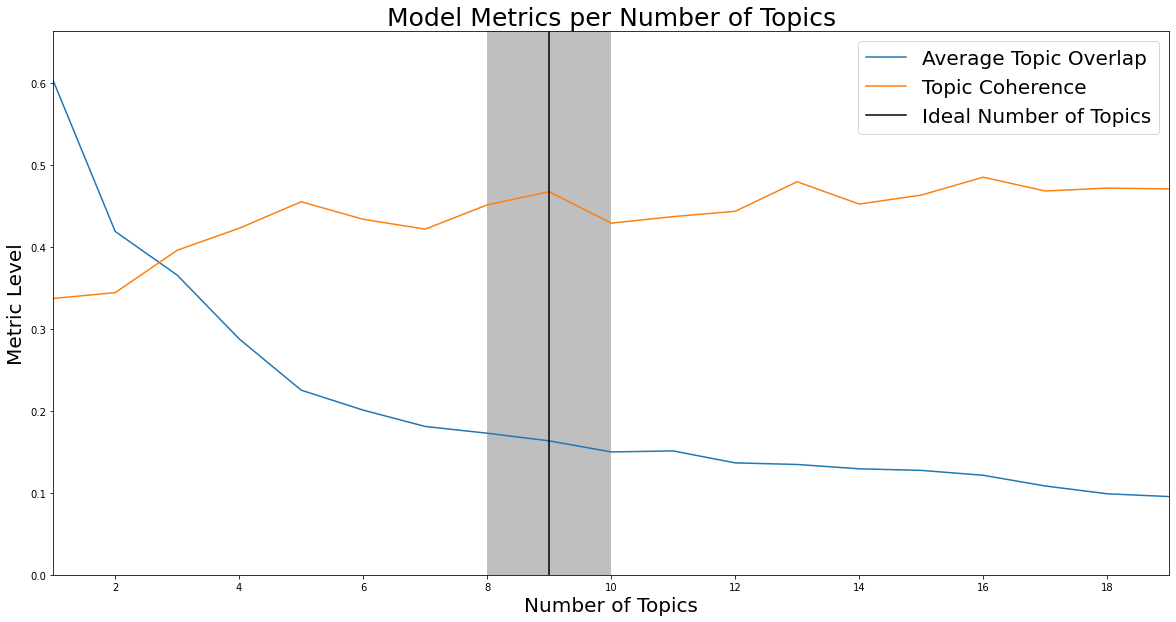

In [26]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()

### According to the model above, the optimal number of topics in the news article dataset is 9.

In [28]:
import gensim
import gensim.corpora as corpora


id2word = corpora.Dictionary(df.text_lda_tokenized) #This creates a corpa out of the tokenized text you provide
corpus = [id2word.doc2bow(text) for text in df.text_lda_tokenized]
#This identifies the positions of the words and the word frequencies
n_topics = 9
ldamodel = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics=n_topics, id2word=id2word, passes=15, random_state=42, workers=5)
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

topics = ldamodel.show_topics(num_words = 10, num_topics = 9, formatted = False)
topics

(0, '0.008*"protest" + 0.007*"govern" + 0.006*"year" + 0.005*"war" + 0.004*"forc" + 0.004*"citi" + 0.004*"month" + 0.004*"countri" + 0.004*"demonstr" + 0.004*"first"')
(1, '0.009*"nigeria" + 0.008*"develop" + 0.008*"technolog" + 0.007*"nigerian" + 0.006*"nation" + 0.005*"africa" + 0.005*"year" + 0.005*"world" + 0.005*"organis" + 0.004*"new"')
(2, '0.011*"presid" + 0.009*"trump" + 0.008*"nation" + 0.006*"new" + 0.006*"state" + 0.005*"unit" + 0.005*"donald" + 0.004*"u" + 0.004*"human" + 0.004*"minist"')
(3, '0.029*"state" + 0.016*"attack" + 0.016*"area" + 0.014*"kill" + 0.012*"boko" + 0.012*"haram" + 0.011*"local" + 0.010*"borno" + 0.010*"armi" + 0.009*"govern"')
(4, '0.025*"kill" + 0.017*"forc" + 0.017*"attack" + 0.016*"air" + 0.013*"state" + 0.012*"terrorist" + 0.011*"oper" + 0.010*"militari" + 0.010*"nigerian" + 0.009*"provinc"')
(5, '0.036*"state" + 0.018*"lago" + 0.012*"road" + 0.010*"accid" + 0.009*"govern" + 0.009*"tanker" + 0.009*"build" + 0.009*"area" + 0.008*"governor" + 0.008*

[(0,
  [('protest', 0.008286956),
   ('govern', 0.0069004465),
   ('year', 0.005756284),
   ('war', 0.0046981266),
   ('forc', 0.004445322),
   ('citi', 0.004220822),
   ('month', 0.0040655932),
   ('countri', 0.004024475),
   ('demonstr', 0.0038685438),
   ('first', 0.0037678955)]),
 (1,
  [('nigeria', 0.008630902),
   ('develop', 0.007887234),
   ('technolog', 0.0077736326),
   ('nigerian', 0.0071380106),
   ('nation', 0.0056356867),
   ('africa', 0.0051089874),
   ('year', 0.0050389897),
   ('world', 0.0047182785),
   ('organis', 0.004559472),
   ('new', 0.0044070138)]),
 (2,
  [('presid', 0.010542161),
   ('trump', 0.008725722),
   ('nation', 0.008114826),
   ('new', 0.006131224),
   ('state', 0.005767569),
   ('unit', 0.0053335303),
   ('donald', 0.0052019767),
   ('u', 0.0041046506),
   ('human', 0.0040863166),
   ('minist', 0.004029168)]),
 (3,
  [('state', 0.029206444),
   ('attack', 0.01602447),
   ('area', 0.015680756),
   ('kill', 0.0142720975),
   ('boko', 0.011603227),
   

---

### **Conclusion:** 

- ### Topic 0 appears related to anti-government protests, possibly related to a war.
- ### Topic 1 appears related to the development of technology in Nigeria, possibly in relation to a new technological organization.
- ### Topic 2 appears related to then U.S. President Donald Trump.
- ### Topic 3 appears related to Nigerian government forces and attacks on or from Boko Haram.
- ### Topic 4 appears related Nigerian military attacks on or from terrorists.
- ### Topic 5 appears related to tanker explosion accidents in Lago State.
- ### Topic 6 appears related to Nigerian President Buhari and possibly connected to human rights.
- ### Topic 7 appears related to police arrests and/or killings of suspects.
- ### Topic 8 appears related to presidential elections.


---
---

## **Sentiment Analysis Section:**



### I use the Valence Aware Dictionary for Sentiment Reasoning (VADER) compound score from the SentimentIntensityAnalyzer for sentiment analysis. VADER is a lexicon and rule-based technque used to analyze sentiment in text. VADER is particularly good at distinguishing subtle differences in the extent of positive or negative sentiment, scoring text appropriately. It can also pick up quite easily on subtle uses of words which in fact reverse the intended meaning of sentences that other sentiment analyzers may not detect. I specifically use VADER's compound score because it is the sum of its positive, negative, and neutral scores, normalized between -1 (extremely negative sentiment) and +1 (extremely positive sentiment).

### One weakness of VADER is that the longer the body of text under consideration the more likely it is that VADER will inflate the compound score for that text. VADER works well with sentence length text, but less well with paragraph length text, and even worse with entire news article length text.

### My approach is therefore the following: I use NLTK's PunktSentenceTokenizer to split up each corpus (news article) into single sentences. I first use PunktSentenceTokenizer to divide each sentence into a new column with each row designated for a particular news article. I then calculate the VADER compound score for each sentence within a given news article, and then find the median VADER compound score among all sentences in each given article. And then among all news articles in the dataset, I find the overall median VADER compound score to detect the general level of sentiment of the news articles as a whole. The reason I use medians rather than means is because taking the mean allows outlier values to affect overall sentiment scores; taking the median is more appropriate when trying to find the "typical" score.

### Further, while the above approach is useful when seeking overall sentiment scores of entire bodies of text as a whole, it is not useful when attempting to break down the entire body of text into individual categories of sentences first (e.g., finding all sentences containing a specific key word in them) before scoring them. For this latter approach, it is important to divide EVERY sentence in the entire news article-based dataset into a separate row using PunktSentenceTokenizer, score each distinct sentence-based row, and then filter the sentences for only those containing the words that are of interest to you so that you can group all such special case sentence rows together in a seperate dataframe, and then find the median VADER compound score among those special-case sentence rows. This is the approach I will also take further below:

In [29]:
q1_senti = df_q1.text.copy()

In [30]:
q1_senti = pd.DataFrame(q1_senti, index=None)

In [31]:
q2_senti = df_q2.text.copy()

In [32]:
q2_senti = pd.DataFrame(q2_senti, index=None)

In [33]:
q3_senti = df_q3.text.copy()

In [34]:
q3_senti = pd.DataFrame(q3_senti, index=None)

In [35]:
q4_senti = df_q4.text.copy()

In [36]:
q4_senti = pd.DataFrame(q4_senti, index=None)

### IT IS IMPORTANT THAT I DO NOT ELIMINATE PERIODS WHEN CLEANING TEXT because doing so would concatonate the text of each corpus. Without periods denoting the endings of sentences, this would not allow me to use the PunktSentenceTokenizer to divide each corpus into sentences and spread them out into multiple columns per row like we would need. I could use text cleaning operations that would remove periods if desired only after dividing corpuses into sentences.

In [37]:
from nltk import PunktSentenceTokenizer

pst = PunktSentenceTokenizer()

In [38]:
pst._params.abbrev_types.add('dr')
pst._params.abbrev_types.add('sen')
pst._params.abbrev_types.add('rep')
pst._params.abbrev_types.add('mr')
pst._params.abbrev_types.add('ms')
pst._params.abbrev_types.add('mrs')
pst._params.abbrev_types.add('u.s')
pst._params.abbrev_types.add('dr.')
pst._params.abbrev_types.add('sen.')
pst._params.abbrev_types.add('rep.')
pst._params.abbrev_types.add('mr.')
pst._params.abbrev_types.add('ms.')
pst._params.abbrev_types.add('mrs.')
pst._params.abbrev_types.add('u.s.')
pst._params.abbrev_types.add('d.c')
pst._params.abbrev_types.add('d.c.')
pst._params.abbrev_types.add('v.s.')
pst._params.abbrev_types.add('v.s')
pst._params.abbrev_types.add('ave.')
pst._params.abbrev_types.add('ave')
pst._params.abbrev_types.add('blvd')
pst._params.abbrev_types.add('blvd.')
pst._params.abbrev_types.add('rd')
pst._params.abbrev_types.add('rd.')
pst._params.abbrev_types.add('st')
pst._params.abbrev_types.add('st.')
pst._params.abbrev_types.add('e.g.')
pst._params.abbrev_types.add('e.g')
pst._params.abbrev_types.add('i.e.')
pst._params.abbrev_types.add('i.e')
pst._params.abbrev_types.add('etc')
pst._params.abbrev_types.add('etc.')
pst._params.abbrev_types.add('p.s.')
pst._params.abbrev_types.add('p.s')
pst._params.abbrev_types.add('u.k.')
pst._params.abbrev_types.add('u.k')
pst._params.abbrev_types.add('e.u')
pst._params.abbrev_types.add('e.u.')
pst._params.abbrev_types.add('u.s.a.')
pst._params.abbrev_types.add('u.s.a')
pst._params.abbrev_types.add('a.m.')
pst._params.abbrev_types.add('a.m')
pst._params.abbrev_types.add('p.m.')
pst._params.abbrev_types.add('p.m')
pst._params.abbrev_types.add('u.a.e.')
pst._params.abbrev_types.add('u.a.e')

## The following technique divides each corpus of sentences (normally in a single column) into one sentence per column for each corpus based-row:

In [39]:
q1_sentences = []
for corpus in q1_senti.text:
    q1_sentences.append(pst.sentences_from_text(corpus))

In [40]:
q2_sentences = []
for corpus in q2_senti.text:
    q2_sentences.append(pst.sentences_from_text(corpus))

In [41]:
q3_sentences = []
for corpus in q3_senti.text:
    q3_sentences.append(pst.sentences_from_text(corpus))

In [42]:
q4_sentences = []
for corpus in q4_senti.text:
    q4_sentences.append(pst.sentences_from_text(corpus))

In [43]:
q1_sentences = pd.DataFrame(q1_sentences, index=None)

In [44]:
q2_sentences = pd.DataFrame(q2_sentences, index=None)

In [45]:
q3_sentences = pd.DataFrame(q3_sentences, index=None)

In [46]:
q4_sentences = pd.DataFrame(q4_sentences, index=None)

In [47]:
q1_sentences.shape

(3158, 143)

### We can see above that there are a total of 3,158 news article-based corpuses in the first quarter dataset, and that the maximum number of sentences in at least one of these news articles is 143.

In [48]:
q1_sentences.head(3)

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
0,the security situation in northern burkina fas...,nearly people have died in intercommunal viole...,this reportedly came after militants killed a ...,a state of emergency has been in place across ...,this gives security forces extra powers.,but the authorities have not deployed any new ...,there is potential for disruptive strikes to o...,the nigeria labour congress nlc the country's ...,and it has that said it is considering organis...,previous nlc strikes over the minimum wage hav...,...,None,None,None,None,None,None,None,None,None,None
1,armed conflict on january at about hrs informa...,the attackers were repelled after security for...,thenumber of casualties is unknown.on january ...,the troops reportedly neutralised an unknown n...,the casualty figure during the operation is no...,the attack was reportedly repelled and theatta...,the number of casualty is unknown.,on january at about hrs according to informati...,subsequently the attack was repelled immediate...,the number of casualties is unknown.,...,None,None,None,None,None,None,None,None,None,None
2,on january the un voiced alarm at the uprootin...,attacks by isis in west africa and the boko ha...,security has become a campaign issue.,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


### Now I take the above dataframe (q1_sentences), and use VADER to create compound scores for each sentence in each of their respective cells above. I then use the same approach for q2_sentences, q3_sentences and q4_sentences: 

In [49]:
def sentiment_fun(var):
    #pip install vaderSentiment
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
    sentiment = SentimentIntensityAnalyzer() 
    out_score = sentiment.polarity_scores(var)
    return out_score['compound']

In [50]:
q1_vader_sentences = [[sentiment_fun(sentence) for sentence in corpus if sentence is not None] for corpus in q1_sentences.values]

In [51]:
q1_vader_sentences_df = pd.DataFrame(q1_vader_sentences)

In [52]:
q2_vader_sentences = [[sentiment_fun(sentence) for sentence in corpus if sentence is not None] for corpus in q2_sentences.values]

In [53]:
q2_vader_sentences_df = pd.DataFrame(q2_vader_sentences)

In [54]:
q3_vader_sentences = [[sentiment_fun(sentence) for sentence in corpus if sentence is not None] for corpus in q3_sentences.values]

In [55]:
q3_vader_sentences_df = pd.DataFrame(q3_vader_sentences)

In [56]:
q4_vader_sentences = [[sentiment_fun(sentence) for sentence in corpus if sentence is not None] for corpus in q4_sentences.values]

In [57]:
q4_vader_sentences_df = pd.DataFrame(q4_vader_sentences)

In [58]:
q1_vader_sentences_df.shape

(3158, 143)

In [59]:
q2_vader_sentences_df.shape

(7269, 143)

In [60]:
q3_vader_sentences_df.shape

(7512, 141)

In [61]:
q4_vader_sentences_df.shape

(6455, 108)

### I want to get rid of all VADER compound scores of 0.0000 because I want to restrict my analysis only to those sentences which convey some sort of sentiment - whether positive or negative - rather than nothing at all. I therefore convert all scores of 0.0000 to NaN, which will allow me to easily remove them later when I remove all NaN values together.

In [62]:
q1_vader_sentences_df.replace(0.0000, np.NaN, inplace=True)

In [63]:
q1_vader_sentences_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
0,-0.2263,-0.8271,-0.8126,-0.3818,0.3400,-0.0387,-0.5859,-0.2263,-0.3612,-0.6124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.2960,0.1027,0.3400,NaN,0.1779,-0.4767,-0.4767,0.5423,-0.1531,0.0772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.8612,-0.2023,0.3400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
q2_vader_sentences_df.replace(0.0000, np.NaN, inplace=True)

In [65]:
q3_vader_sentences_df.replace(0.0000, np.NaN, inplace=True)

In [66]:
q4_vader_sentences_df.replace(0.0000, np.NaN, inplace=True)

### Here, I calculate the median score (row-wise across columns) for each row within each of the 4 dataframes:

In [67]:
q1_sentences_vader_medians = q1_vader_sentences_df.median(axis=1, skipna=True)

In [68]:
q2_sentences_vader_medians = q2_vader_sentences_df.median(axis=1, skipna=True)

In [69]:
q3_sentences_vader_medians = q3_vader_sentences_df.median(axis=1, skipna=True)

In [70]:
q4_sentences_vader_medians = q4_vader_sentences_df.median(axis=1, skipna=True)

### Here, I calculate the overall median score (by taking the median value across all rows) for each of the 4 dataframes:

In [71]:
q1_overall_median_vader_score = q1_sentences_vader_medians.median(axis=0, skipna=True)

In [72]:
print(q1_overall_median_vader_score)

-0.3818


In [73]:
q2_overall_median_vader_score = q2_sentences_vader_medians.median(axis=0, skipna=True)

In [74]:
print(q2_overall_median_vader_score)

-0.3818


In [75]:
q3_overall_median_vader_score = q3_sentences_vader_medians.median(axis=0, skipna=True)

In [76]:
print(q3_overall_median_vader_score)

-0.36569999999999997


In [77]:
q4_overall_median_vader_score = q4_sentences_vader_medians.median(axis=0, skipna=True)

In [78]:
print(q4_overall_median_vader_score)

-0.31875


### Next, I want to calculate the VADER compound scores for each sentence in each quarter of the 2019 news articles rather than simply finding the overall median VADER compound scores for each quarter. Finding the VADER compound scores for each sentence will allow me to eventually filter for sentences containing certain key words and then to calculate the median VADER compound scores just for these filtered categories of sentences. 

### I now make it so *each sentence* comprises a single row and single column throughout the entire news article dataset (rather than having each row representative of a single news article, split into one column per sentence as before). Each sentence-based row is placed in one of four datasets depending on the 2019 quarter the article was written in:

In [79]:
from itertools import chain

q1_one_sentence_per_row = list(chain.from_iterable(q1_sentences.values))

In [80]:
q2_one_sentence_per_row = list(chain.from_iterable(q2_sentences.values))

In [81]:
q3_one_sentence_per_row = list(chain.from_iterable(q3_sentences.values))

In [82]:
q4_one_sentence_per_row = list(chain.from_iterable(q4_sentences.values))

### Before (with q1_sentences, q2_sentences, q3_sentences, and q4_sentences) all columns following the last sentence in each news article-based row contained "NaN" missing values. When I reconstructed each dataframe (above) so that each row (now having just one column) represented an individual sentence, I ended up with all these "NaN" values becoming new separate rows. I now want to remove all such "NaN" missing value-based rows from each list so that each row will truly be a sentence rather than containing missing values. I use len() before and after removing NaN values to show the number of rows that were removed from each of the four lists because of missing values:

In [83]:
len(q1_one_sentence_per_row)

451594

In [84]:
q1_one_sentence_per_row = list(filter(None, q1_one_sentence_per_row))

In [85]:
len(q1_one_sentence_per_row)

8139

In [86]:
q1_one_sentence_per_row = pd.DataFrame(q1_one_sentence_per_row)

In [87]:
len(q2_one_sentence_per_row)

1039467

In [88]:
q2_one_sentence_per_row = list(filter(None, q2_one_sentence_per_row))

In [89]:
len(q2_one_sentence_per_row)

17137

In [90]:
q2_one_sentence_per_row = pd.DataFrame(q2_one_sentence_per_row)

In [91]:
len(q3_one_sentence_per_row)

1059192

In [92]:
q3_one_sentence_per_row = list(filter(None, q3_one_sentence_per_row))

In [93]:
len(q3_one_sentence_per_row)

18121

In [94]:
q3_one_sentence_per_row = pd.DataFrame(q3_one_sentence_per_row)

In [95]:
len(q4_one_sentence_per_row)

697140

In [96]:
q4_one_sentence_per_row = list(filter(None, q4_one_sentence_per_row))

In [97]:
len(q4_one_sentence_per_row)

16141

In [98]:
q4_one_sentence_per_row = pd.DataFrame(q4_one_sentence_per_row)

### I now take each of the four quarterly dataframes composed of one sentence per row, and create a VADER compound score for each sentence within each dataset:

In [99]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [100]:
q1_one_sentence_per_row['vader'] = q1_one_sentence_per_row[0].apply(sentiment_fun)

In [101]:
q1_one_sentence_per_row.rename(columns = {0:'text'}, inplace = True)

In [102]:
q2_one_sentence_per_row['vader'] = q2_one_sentence_per_row[0].apply(sentiment_fun)

In [103]:
q2_one_sentence_per_row.rename(columns = {0:'text'}, inplace = True)

In [104]:
q3_one_sentence_per_row['vader'] = q3_one_sentence_per_row[0].apply(sentiment_fun)

In [105]:
q3_one_sentence_per_row.rename(columns = {0:'text'}, inplace = True)

In [106]:
q4_one_sentence_per_row['vader'] = q4_one_sentence_per_row[0].apply(sentiment_fun)

In [107]:
q4_one_sentence_per_row.rename(columns = {0:'text'}, inplace = True)

### I now use pandas describe() to show descriptive statistics for the VADER compound scores of each special sentence category within each dataframe. I also hone in specifically on the median score, because I will in the end create a visualization (with R Markdown) using the median scores. The first sentence category below, called "All Words", shows the descriptive statistics of VADER compound scores before any filtering for sentences containing specific words occurs:

---

### All Words:

In [108]:
q1_one_sentence_per_row_vader_no_zeros = q1_one_sentence_per_row.vader[q1_one_sentence_per_row['vader'] != float(0.000000)]

In [109]:
q1_one_sentence_per_row_vader_no_zeros.describe()

count    5825.000000
mean       -0.245656
std         0.528684
min        -0.980800
25%        -0.690800
50%        -0.401900
75%         0.250000
max         0.960100
Name: vader, dtype: float64

In [110]:
q1_one_sentence_per_row_vader_no_zeros.median(axis=0)

-0.4019

In [111]:
q2_one_sentence_per_row_vader_no_zeros = q2_one_sentence_per_row.vader[q2_one_sentence_per_row['vader'] != float(0.000000)]

In [112]:
q2_one_sentence_per_row_vader_no_zeros.describe()

count    11787.000000
mean        -0.261280
std          0.529099
min         -0.987300
25%         -0.700300
50%         -0.421500
75%          0.238200
max          0.963300
Name: vader, dtype: float64

In [113]:
q2_one_sentence_per_row_vader_no_zeros.median(axis=0)

-0.4215

In [114]:
q3_one_sentence_per_row_vader_no_zeros = q3_one_sentence_per_row.vader[q3_one_sentence_per_row['vader'] != float(0.000000)]

In [115]:
q3_one_sentence_per_row_vader_no_zeros.describe()

count    12421.000000
mean        -0.256102
std          0.524448
min         -0.989300
25%         -0.695600
50%         -0.421500
75%          0.238200
max          0.971600
Name: vader, dtype: float64

In [116]:
q3_one_sentence_per_row_vader_no_zeros.median(axis=0)

-0.4215

In [117]:
q4_one_sentence_per_row_vader_no_zeros = q4_one_sentence_per_row.vader[q4_one_sentence_per_row['vader'] != float(0.000000)]

In [118]:
q4_one_sentence_per_row_vader_no_zeros.describe()

count    10736.000000
mean        -0.233173
std          0.537499
min         -0.980800
25%         -0.680800
50%         -0.401900
75%          0.296000
max          0.966100
Name: vader, dtype: float64

In [119]:
q4_one_sentence_per_row_vader_no_zeros.median(axis=0)

-0.4019

### Sentences containing the word "election" or "elections":

In [120]:
q1_one_sentence_per_row_elections = pd.DataFrame(q1_one_sentence_per_row[q1_one_sentence_per_row.text.str.contains("election") | q1_one_sentence_per_row.text.str.contains("elections")])

In [121]:
q1_one_sentence_per_row_elections_vader_no_zeros = q1_one_sentence_per_row_elections.vader[q1_one_sentence_per_row_elections['vader'] != float(0.000000)]

In [122]:
q1_one_sentence_per_row_elections_vader_no_zeros.describe()

count    355.000000
mean      -0.085052
std        0.545170
min       -0.933700
25%       -0.602400
50%       -0.161100
75%        0.440400
max        0.902300
Name: vader, dtype: float64

In [123]:
q1_one_sentence_per_row_elections_vader_no_zeros.median(axis=0)

-0.1611

In [124]:
q2_one_sentence_per_row_elections = pd.DataFrame(q2_one_sentence_per_row[q2_one_sentence_per_row.text.str.contains("election") | q2_one_sentence_per_row.text.str.contains("elections")])

In [125]:
q2_one_sentence_per_row_elections_vader_no_zeros = q2_one_sentence_per_row_elections.vader[q2_one_sentence_per_row_elections['vader'] != float(0.000000)]

In [126]:
q2_one_sentence_per_row_elections_vader_no_zeros.describe()

count    163.000000
mean       0.045700
std        0.554379
min       -0.948500
25%       -0.449600
50%        0.077200
75%        0.571900
max        0.886000
Name: vader, dtype: float64

In [127]:
q2_one_sentence_per_row_elections_vader_no_zeros.median(axis=0)

0.0772

In [128]:
q3_one_sentence_per_row_elections = pd.DataFrame(q3_one_sentence_per_row[q3_one_sentence_per_row.text.str.contains("election") | q3_one_sentence_per_row.text.str.contains("elections")])

In [129]:
q3_one_sentence_per_row_elections_vader_no_zeros = q3_one_sentence_per_row_elections.vader[q3_one_sentence_per_row_elections['vader'] != float(0.000000)]

In [130]:
q3_one_sentence_per_row_elections_vader_no_zeros.describe()

count    158.000000
mean      -0.099552
std        0.508252
min       -0.932500
25%       -0.568275
50%       -0.153100
75%        0.401900
max        0.812600
Name: vader, dtype: float64

In [131]:
q3_one_sentence_per_row_elections_vader_no_zeros.median(axis=0)

-0.1531

In [132]:
q4_one_sentence_per_row_elections = pd.DataFrame(q4_one_sentence_per_row[q4_one_sentence_per_row.text.str.contains("election") | q4_one_sentence_per_row.text.str.contains("elections")])

In [133]:
q4_one_sentence_per_row_elections_vader_no_zeros = q4_one_sentence_per_row_elections.vader[q4_one_sentence_per_row_elections['vader'] != float(0.000000)]

In [134]:
q4_one_sentence_per_row_elections_vader_no_zeros.describe()

count    122.000000
mean      -0.020583
std        0.564596
min       -0.941300
25%       -0.522675
50%       -0.054400
75%        0.476700
max        0.900100
Name: vader, dtype: float64

In [135]:
q4_one_sentence_per_row_elections_vader_no_zeros.median(axis=0)

-0.054400000000000004

### Sentences containing the word "protest", "protests", "protester", or "protesters":

In [136]:
q1_one_sentence_per_row_protests = pd.DataFrame(q1_one_sentence_per_row[q1_one_sentence_per_row.text.str.contains("protest") | q1_one_sentence_per_row.text.str.contains("protests") | q1_one_sentence_per_row.text.str.contains("protester") | q1_one_sentence_per_row.text.str.contains("protesters")])

In [137]:
q1_one_sentence_per_row_protests_vader_no_zeros = q1_one_sentence_per_row_protests.vader[q1_one_sentence_per_row_protests['vader'] != float(0.000000)]

In [138]:
q1_one_sentence_per_row_protests_vader_no_zeros.describe()

count    183.000000
mean      -0.305215
std        0.413701
min       -0.945100
25%       -0.648600
50%       -0.294400
75%       -0.128000
max        0.893400
Name: vader, dtype: float64

In [139]:
q1_one_sentence_per_row_protests_vader_no_zeros.median(axis=0)

-0.2944

In [140]:
q2_one_sentence_per_row_protests = pd.DataFrame(q2_one_sentence_per_row[q2_one_sentence_per_row.text.str.contains("protest") | q2_one_sentence_per_row.text.str.contains("protests") | q2_one_sentence_per_row.text.str.contains("protester") | q2_one_sentence_per_row.text.str.contains("protesters")])

In [141]:
q2_one_sentence_per_row_protests_vader_no_zeros = q2_one_sentence_per_row_protests.vader[q2_one_sentence_per_row_protests['vader'] != float(0.000000)]

In [142]:
q2_one_sentence_per_row_protests_vader_no_zeros.describe()

count    259.000000
mean      -0.361518
std        0.404511
min       -0.972300
25%       -0.695550
50%       -0.421500
75%       -0.214300
max        0.877900
Name: vader, dtype: float64

In [143]:
q2_one_sentence_per_row_protests_vader_no_zeros.median(axis=0)

-0.4215

In [144]:
q3_one_sentence_per_row_protests = pd.DataFrame(q3_one_sentence_per_row[q3_one_sentence_per_row.text.str.contains("protest") | q3_one_sentence_per_row.text.str.contains("protests") | q3_one_sentence_per_row.text.str.contains("protester") | q3_one_sentence_per_row.text.str.contains("protesters")])

In [145]:
q3_one_sentence_per_row_protests_vader_no_zeros = q3_one_sentence_per_row_protests.vader[q3_one_sentence_per_row_protests['vader'] != float(0.000000)]

In [146]:
q3_one_sentence_per_row_protests_vader_no_zeros.describe()

count    543.000000
mean      -0.461390
std        0.382368
min       -0.957800
25%       -0.775000
50%       -0.542300
75%       -0.226300
max        0.851100
Name: vader, dtype: float64

In [147]:
q3_one_sentence_per_row_protests_vader_no_zeros.median(axis=0)

-0.5423

In [148]:
q4_one_sentence_per_row_protests = pd.DataFrame(q4_one_sentence_per_row[q4_one_sentence_per_row.text.str.contains("protest") | q4_one_sentence_per_row.text.str.contains("protests") | q4_one_sentence_per_row.text.str.contains("protester") | q4_one_sentence_per_row.text.str.contains("protesters")])

In [149]:
q4_one_sentence_per_row_protests_vader_no_zeros = q4_one_sentence_per_row_protests.vader[q4_one_sentence_per_row_protests['vader'] != float(0.000000)]

In [150]:
q4_one_sentence_per_row_protests_vader_no_zeros.describe()

count    299.000000
mean      -0.441024
std        0.373076
min       -0.945100
25%       -0.734700
50%       -0.526700
75%       -0.226300
max        0.800500
Name: vader, dtype: float64

In [151]:
q4_one_sentence_per_row_protests_vader_no_zeros.median(axis=0)

-0.5267

### Sentences containing the word "rights", "freedom", "liberty", or "liberties":

In [152]:
q1_one_sentence_per_row_rights = pd.DataFrame(q1_one_sentence_per_row[q1_one_sentence_per_row.text.str.contains("rights") | q1_one_sentence_per_row.text.str.contains("freedom") | q1_one_sentence_per_row.text.str.contains("liberty") | q1_one_sentence_per_row.text.str.contains("liberties")])

In [153]:
q1_one_sentence_per_row_rights_vader_no_zeros = q1_one_sentence_per_row_rights.vader[q1_one_sentence_per_row_rights['vader'] != float(0.000000)]

In [154]:
q1_one_sentence_per_row_rights_vader_no_zeros.describe()

count    135.000000
mean      -0.160793
std        0.594134
min       -0.980800
25%       -0.700200
50%       -0.296000
75%        0.371500
max        0.944200
Name: vader, dtype: float64

In [155]:
q1_one_sentence_per_row_rights_vader_no_zeros.median(axis=0)

-0.296

In [156]:
q2_one_sentence_per_row_rights = pd.DataFrame(q2_one_sentence_per_row[q2_one_sentence_per_row.text.str.contains("rights") | q2_one_sentence_per_row.text.str.contains("freedom") | q2_one_sentence_per_row.text.str.contains("liberty") | q2_one_sentence_per_row.text.str.contains("liberties")])

In [157]:
q2_one_sentence_per_row_rights_vader_no_zeros = q2_one_sentence_per_row_rights.vader[q2_one_sentence_per_row_rights['vader'] != float(0.000000)]

In [158]:
q2_one_sentence_per_row_rights_vader_no_zeros.describe()

count    323.000000
mean      -0.084218
std        0.588692
min       -0.971600
25%       -0.624900
50%       -0.177900
75%        0.485300
max        0.954500
Name: vader, dtype: float64

In [159]:
q2_one_sentence_per_row_rights_vader_no_zeros.median(axis=0)

-0.1779

In [160]:
q3_one_sentence_per_row_rights = pd.DataFrame(q3_one_sentence_per_row[q3_one_sentence_per_row.text.str.contains("rights") | q3_one_sentence_per_row.text.str.contains("freedom") | q3_one_sentence_per_row.text.str.contains("liberty") | q3_one_sentence_per_row.text.str.contains("liberties")])

In [161]:
q3_one_sentence_per_row_rights_vader_no_zeros = q3_one_sentence_per_row_rights.vader[q3_one_sentence_per_row_rights['vader'] != float(0.000000)]

In [162]:
q3_one_sentence_per_row_rights_vader_no_zeros.describe()

count    379.000000
mean      -0.113163
std        0.557515
min       -0.938200
25%       -0.618650
50%       -0.273200
75%        0.421500
max        0.911800
Name: vader, dtype: float64

In [163]:
q3_one_sentence_per_row_rights_vader_no_zeros.median(axis=0)

-0.2732

In [164]:
q4_one_sentence_per_row_rights = pd.DataFrame(q4_one_sentence_per_row[q4_one_sentence_per_row.text.str.contains("rights") | q4_one_sentence_per_row.text.str.contains("freedom") | q4_one_sentence_per_row.text.str.contains("liberty") | q4_one_sentence_per_row.text.str.contains("liberties")])

In [165]:
q4_one_sentence_per_row_rights_vader_no_zeros = q4_one_sentence_per_row_rights.vader[q4_one_sentence_per_row_rights['vader'] != float(0.000000)]

In [166]:
q4_one_sentence_per_row_rights_vader_no_zeros.describe()

count    426.000000
mean      -0.004027
std        0.572954
min       -0.953800
25%       -0.510600
50%       -0.064400
75%        0.526700
max        0.950900
Name: vader, dtype: float64

In [167]:
q4_one_sentence_per_row_rights_vader_no_zeros.median(axis=0)

-0.0644

### Sentences containing the word "government":

In [168]:
q1_one_sentence_per_row_government = pd.DataFrame(q1_one_sentence_per_row[q1_one_sentence_per_row.text.str.contains("government")])

In [169]:
q1_one_sentence_per_row_government_vader_no_zeros = q1_one_sentence_per_row_government.vader[q1_one_sentence_per_row_government['vader'] != float(0.000000)]

In [170]:
q1_one_sentence_per_row_government_vader_no_zeros.describe()

count    568.000000
mean      -0.354443
std        0.501744
min       -0.972300
25%       -0.735100
50%       -0.526700
75%       -0.025800
max        0.954500
Name: vader, dtype: float64

In [171]:
q1_one_sentence_per_row_government_vader_no_zeros.median(axis=0)

-0.5267

In [172]:
q2_one_sentence_per_row_government = pd.DataFrame(q2_one_sentence_per_row[q2_one_sentence_per_row.text.str.contains("government")])

In [173]:
q2_one_sentence_per_row_government_vader_no_zeros = q2_one_sentence_per_row_government.vader[q2_one_sentence_per_row_government['vader'] != float(0.000000)]

In [174]:
q2_one_sentence_per_row_government_vader_no_zeros.describe()

count    1205.000000
mean       -0.330578
std         0.520185
min        -0.972300
25%        -0.771700
50%        -0.493900
75%         0.077200
max         0.950900
Name: vader, dtype: float64

In [175]:
q2_one_sentence_per_row_government_vader_no_zeros.median(axis=0)

-0.4939

In [176]:
q3_one_sentence_per_row_government = pd.DataFrame(q3_one_sentence_per_row[q3_one_sentence_per_row.text.str.contains("government")])

In [177]:
q3_one_sentence_per_row_government_vader_no_zeros = q3_one_sentence_per_row_government.vader[q3_one_sentence_per_row_government['vader'] != float(0.000000)]

In [178]:
q3_one_sentence_per_row_government_vader_no_zeros.describe()

count    1332.000000
mean       -0.287866
std         0.525666
min        -0.989300
25%        -0.735100
50%        -0.458800
75%         0.153100
max         0.932500
Name: vader, dtype: float64

In [179]:
q3_one_sentence_per_row_government_vader_no_zeros.median(axis=0)

-0.4588

In [180]:
q4_one_sentence_per_row_government = pd.DataFrame(q4_one_sentence_per_row[q4_one_sentence_per_row.text.str.contains("government")])

In [181]:
q4_one_sentence_per_row_government_vader_no_zeros = q4_one_sentence_per_row_government.vader[q4_one_sentence_per_row_government['vader'] != float(0.000000)]

In [182]:
q4_one_sentence_per_row_government_vader_no_zeros.describe()

count    1003.000000
mean       -0.260251
std         0.546112
min        -0.964300
25%        -0.726900
50%        -0.440400
75%         0.273200
max         0.921700
Name: vader, dtype: float64

In [183]:
q4_one_sentence_per_row_government_vader_no_zeros.median(axis=0)

-0.4404

### Sentences containing the words "Nigerian army":

In [184]:
q1_one_sentence_per_row_army = pd.DataFrame(q1_one_sentence_per_row[q1_one_sentence_per_row.text.str.contains("nigerian army")])

In [185]:
q1_one_sentence_per_row_army_vader_no_zeros = q1_one_sentence_per_row_army.vader[q1_one_sentence_per_row_army['vader'] != float(0.000000)]

In [186]:
q1_one_sentence_per_row_army_vader_no_zeros.describe()

count    48.000000
mean     -0.331706
std       0.551908
min      -0.934900
25%      -0.788875
50%      -0.485300
75%       0.063825
max       0.822100
Name: vader, dtype: float64

In [187]:
q1_one_sentence_per_row_army_vader_no_zeros.median(axis=0)

-0.4853

In [188]:
q2_one_sentence_per_row_army = pd.DataFrame(q2_one_sentence_per_row[q2_one_sentence_per_row.text.str.contains("nigerian army")])

In [189]:
q2_one_sentence_per_row_army_vader_no_zeros = q2_one_sentence_per_row_army.vader[q2_one_sentence_per_row_army['vader'] != float(0.000000)]

In [190]:
q2_one_sentence_per_row_army_vader_no_zeros.describe()

count    201.000000
mean      -0.590305
std        0.418051
min       -0.962800
25%       -0.862500
50%       -0.778300
75%       -0.476700
max        0.875000
Name: vader, dtype: float64

In [191]:
q2_one_sentence_per_row_army_vader_no_zeros.median(axis=0)

-0.7783

In [192]:
q3_one_sentence_per_row_army = pd.DataFrame(q3_one_sentence_per_row[q3_one_sentence_per_row.text.str.contains("nigerian army")])

In [193]:
q3_one_sentence_per_row_army_vader_no_zeros = q3_one_sentence_per_row_army.vader[q3_one_sentence_per_row_army['vader'] != float(0.000000)]

In [194]:
q3_one_sentence_per_row_army_vader_no_zeros.describe()

count    270.000000
mean      -0.422124
std        0.501534
min       -0.971600
25%       -0.840200
50%       -0.636750
75%       -0.128000
max        0.807400
Name: vader, dtype: float64

In [195]:
q3_one_sentence_per_row_army_vader_no_zeros.median(axis=0)

-0.6367499999999999

In [196]:
q4_one_sentence_per_row_army = pd.DataFrame(q4_one_sentence_per_row[q4_one_sentence_per_row.text.str.contains("nigerian army")])

In [197]:
q4_one_sentence_per_row_army_vader_no_zeros = q4_one_sentence_per_row_army.vader[q4_one_sentence_per_row_army['vader'] != float(0.000000)]

In [198]:
q4_one_sentence_per_row_army_vader_no_zeros.describe()

count    180.000000
mean      -0.266293
std        0.575530
min       -0.960100
25%       -0.771700
50%       -0.421500
75%        0.361200
max        0.857300
Name: vader, dtype: float64

In [199]:
q4_one_sentence_per_row_army_vader_no_zeros.median(axis=0)

-0.4215

### Sentences containing the word "police":

In [200]:
q1_one_sentence_per_row_police = pd.DataFrame(q1_one_sentence_per_row[q1_one_sentence_per_row.text.str.contains("police")])

In [201]:
q1_one_sentence_per_row_police_vader_no_zeros = q1_one_sentence_per_row_police.vader[q1_one_sentence_per_row_police['vader'] != float(0.000000)]

In [202]:
q1_one_sentence_per_row_police_vader_no_zeros.describe()

count    283.000000
mean      -0.515807
std        0.412829
min       -0.953800
25%       -0.815100
50%       -0.670500
75%       -0.389200
max        0.831600
Name: vader, dtype: float64

In [203]:
q1_one_sentence_per_row_police_vader_no_zeros.median(axis=0)

-0.6705

In [204]:
q2_one_sentence_per_row_police = pd.DataFrame(q2_one_sentence_per_row[q2_one_sentence_per_row.text.str.contains("police")])

In [205]:
q2_one_sentence_per_row_police_vader_no_zeros = q2_one_sentence_per_row_police.vader[q2_one_sentence_per_row_police['vader'] != float(0.000000)]

In [206]:
q2_one_sentence_per_row_police_vader_no_zeros.describe()

count    762.000000
mean      -0.475327
std        0.436995
min       -0.978100
25%       -0.807300
50%       -0.624900
75%       -0.300750
max        0.844200
Name: vader, dtype: float64

In [207]:
q2_one_sentence_per_row_police_vader_no_zeros.median(axis=0)

-0.6249

In [208]:
q3_one_sentence_per_row_police = pd.DataFrame(q3_one_sentence_per_row[q3_one_sentence_per_row.text.str.contains("police")])

In [209]:
q3_one_sentence_per_row_police_vader_no_zeros = q3_one_sentence_per_row_police.vader[q3_one_sentence_per_row_police['vader'] != float(0.000000)]

In [210]:
q3_one_sentence_per_row_police_vader_no_zeros.describe()

count    1158.000000
mean       -0.470303
std         0.440810
min        -0.969800
25%        -0.790600
50%        -0.648600
75%        -0.296000
max         0.884700
Name: vader, dtype: float64

In [211]:
q3_one_sentence_per_row_police_vader_no_zeros.median(axis=0)

-0.6486

In [212]:
q4_one_sentence_per_row_police = pd.DataFrame(q4_one_sentence_per_row[q4_one_sentence_per_row.text.str.contains("police")])

In [213]:
q4_one_sentence_per_row_police_vader_no_zeros = q4_one_sentence_per_row_police.vader[q4_one_sentence_per_row_police['vader'] != float(0.000000)]

In [214]:
q4_one_sentence_per_row_police_vader_no_zeros.describe()

count    680.000000
mean      -0.464350
std        0.437471
min       -0.976900
25%       -0.790600
50%       -0.605900
75%       -0.337275
max        0.889800
Name: vader, dtype: float64

In [215]:
q4_one_sentence_per_row_police_vader_no_zeros.median(axis=0)

-0.6059000000000001

### Sentences containing the word "justice system", "judicial system", "judiciary", "court system", "court", or "courts":

In [216]:
q1_one_sentence_per_row_courts = pd.DataFrame(q1_one_sentence_per_row[q1_one_sentence_per_row.text.str.contains("justice system") | q1_one_sentence_per_row.text.str.contains("judicial system") | q1_one_sentence_per_row.text.str.contains("judiciary") | q1_one_sentence_per_row.text.str.contains("court system") | q1_one_sentence_per_row.text.str.contains("court") | q1_one_sentence_per_row.text.str.contains("courts")])

In [217]:
q1_one_sentence_per_row_courts_vader_no_zeros = q1_one_sentence_per_row_courts.vader[q1_one_sentence_per_row_courts['vader'] != float(0.000000)]

In [218]:
q1_one_sentence_per_row_courts_vader_no_zeros.describe()

count    142.000000
mean      -0.223411
std        0.529118
min       -0.946000
25%       -0.719875
50%       -0.284600
75%        0.226300
max        0.946000
Name: vader, dtype: float64

In [219]:
q1_one_sentence_per_row_courts_vader_no_zeros.median(axis=0)

-0.28459999999999996

In [220]:
q2_one_sentence_per_row_courts = pd.DataFrame(q2_one_sentence_per_row[q2_one_sentence_per_row.text.str.contains("justice system") | q2_one_sentence_per_row.text.str.contains("judicial system") | q2_one_sentence_per_row.text.str.contains("judiciary") | q2_one_sentence_per_row.text.str.contains("court system") | q2_one_sentence_per_row.text.str.contains("court") | q2_one_sentence_per_row.text.str.contains("courts")])

In [221]:
q2_one_sentence_per_row_courts_vader_no_zeros = q2_one_sentence_per_row_courts.vader[q2_one_sentence_per_row_courts['vader'] != float(0.000000)]

In [222]:
q2_one_sentence_per_row_courts_vader_no_zeros.describe()

count    207.000000
mean      -0.180316
std        0.532890
min       -0.944000
25%       -0.648600
50%       -0.361200
75%        0.329100
max        0.902200
Name: vader, dtype: float64

In [223]:
q2_one_sentence_per_row_courts_vader_no_zeros.median(axis=0)

-0.3612

In [224]:
q3_one_sentence_per_row_courts = pd.DataFrame(q3_one_sentence_per_row[q3_one_sentence_per_row.text.str.contains("justice system") | q3_one_sentence_per_row.text.str.contains("judicial system") | q3_one_sentence_per_row.text.str.contains("judiciary") | q3_one_sentence_per_row.text.str.contains("court system") | q3_one_sentence_per_row.text.str.contains("court") | q3_one_sentence_per_row.text.str.contains("courts")])

In [225]:
q3_one_sentence_per_row_courts_vader_no_zeros = q3_one_sentence_per_row_courts.vader[q3_one_sentence_per_row_courts['vader'] != float(0.000000)]

In [226]:
q3_one_sentence_per_row_courts_vader_no_zeros.describe()

count    271.000000
mean      -0.157954
std        0.576899
min       -0.967000
25%       -0.690800
50%       -0.296000
75%        0.371500
max        0.888500
Name: vader, dtype: float64

In [227]:
q3_one_sentence_per_row_courts_vader_no_zeros.median(axis=0)

-0.296

In [228]:
q4_one_sentence_per_row_courts = pd.DataFrame(q4_one_sentence_per_row[q4_one_sentence_per_row.text.str.contains("justice system") | q4_one_sentence_per_row.text.str.contains("judicial system") | q4_one_sentence_per_row.text.str.contains("judiciary") | q4_one_sentence_per_row.text.str.contains("court system") | q4_one_sentence_per_row.text.str.contains("court") | q4_one_sentence_per_row.text.str.contains("courts")])

In [229]:
q4_one_sentence_per_row_courts_vader_no_zeros = q4_one_sentence_per_row_courts.vader[q4_one_sentence_per_row_courts['vader'] != float(0.000000)]

In [230]:
q4_one_sentence_per_row_courts_vader_no_zeros.describe()

count    291.000000
mean      -0.123811
std        0.577444
min       -0.980800
25%       -0.659700
50%       -0.250000
75%        0.421500
max        0.906200
Name: vader, dtype: float64

In [231]:
q4_one_sentence_per_row_courts_vader_no_zeros.median(axis=0)

-0.25

### Sentences containing the words "Boko Haram":

In [232]:
q1_one_sentence_per_row_boko_haram = pd.DataFrame(q1_one_sentence_per_row[q1_one_sentence_per_row.text.str.contains("boko haram")])

In [233]:
q1_one_sentence_per_row_boko_haram_vader_no_zeros = q1_one_sentence_per_row_boko_haram.vader[q1_one_sentence_per_row_boko_haram['vader'] != float(0.000000)]

In [234]:
q1_one_sentence_per_row_boko_haram_vader_no_zeros.describe()

count    288.000000
mean      -0.508719
std        0.425532
min       -0.968200
25%       -0.822500
50%       -0.670500
75%       -0.361200
max        0.836600
Name: vader, dtype: float64

In [235]:
q1_one_sentence_per_row_boko_haram_vader_no_zeros.median(axis=0)

-0.6705

In [236]:
q2_one_sentence_per_row_boko_haram = pd.DataFrame(q2_one_sentence_per_row[q2_one_sentence_per_row.text.str.contains("boko haram")])

In [237]:
q2_one_sentence_per_row_boko_haram_vader_no_zeros = q2_one_sentence_per_row_boko_haram.vader[q2_one_sentence_per_row_boko_haram['vader'] != float(0.000000)]

In [238]:
q2_one_sentence_per_row_boko_haram_vader_no_zeros.describe()

count    644.000000
mean      -0.531293
std        0.441749
min       -0.964800
25%       -0.862500
50%       -0.680800
75%       -0.381800
max        0.963300
Name: vader, dtype: float64

In [239]:
q2_one_sentence_per_row_boko_haram_vader_no_zeros.median(axis=0)

-0.6808

In [240]:
q3_one_sentence_per_row_boko_haram = pd.DataFrame(q3_one_sentence_per_row[q3_one_sentence_per_row.text.str.contains("boko haram")])

In [241]:
q3_one_sentence_per_row_boko_haram_vader_no_zeros = q3_one_sentence_per_row_boko_haram.vader[q3_one_sentence_per_row_boko_haram['vader'] != float(0.000000)]

In [242]:
q3_one_sentence_per_row_boko_haram_vader_no_zeros.describe()

count    703.000000
mean      -0.533254
std        0.400835
min       -0.971600
25%       -0.859100
50%       -0.624900
75%       -0.381800
max        0.844200
Name: vader, dtype: float64

In [243]:
q3_one_sentence_per_row_boko_haram_vader_no_zeros.median(axis=0)

-0.6249

In [244]:
q4_one_sentence_per_row_boko_haram = pd.DataFrame(q4_one_sentence_per_row[q4_one_sentence_per_row.text.str.contains("boko haram")])

In [245]:
q4_one_sentence_per_row_boko_haram_vader_no_zeros = q4_one_sentence_per_row_boko_haram.vader[q4_one_sentence_per_row_boko_haram['vader'] != float(0.000000)]

In [246]:
q4_one_sentence_per_row_boko_haram_vader_no_zeros.describe()

count    500.000000
mean      -0.521087
std        0.432834
min       -0.969400
25%       -0.849050
50%       -0.670500
75%       -0.334550
max        0.784100
Name: vader, dtype: float64

In [247]:
q4_one_sentence_per_row_boko_haram_vader_no_zeros.median(axis=0)

-0.6705

### Sentences containing the word "Islamic State", "ISIS", or "ISIL":

In [248]:
q1_one_sentence_per_row_isis = pd.DataFrame(q1_one_sentence_per_row[q1_one_sentence_per_row.text.str.contains("islamic state") | q1_one_sentence_per_row.text.str.contains("isis") | q1_one_sentence_per_row.text.str.contains("isil")])

In [249]:
q1_one_sentence_per_row_isis_vader_no_zeros = q1_one_sentence_per_row_isis.vader[q1_one_sentence_per_row_isis['vader'] != float(0.000000)]

In [250]:
q1_one_sentence_per_row_isis_vader_no_zeros.describe()

count    144.000000
mean      -0.569021
std        0.339280
min       -0.955200
25%       -0.812600
50%       -0.642750
75%       -0.401900
max        0.784500
Name: vader, dtype: float64

In [251]:
q1_one_sentence_per_row_isis_vader_no_zeros.median(axis=0)

-0.6427499999999999

In [252]:
q2_one_sentence_per_row_isis = pd.DataFrame(q2_one_sentence_per_row[q2_one_sentence_per_row.text.str.contains("islamic state") | q2_one_sentence_per_row.text.str.contains("isis") | q2_one_sentence_per_row.text.str.contains("isil")])

In [253]:
q2_one_sentence_per_row_isis_vader_no_zeros = q2_one_sentence_per_row_isis.vader[q2_one_sentence_per_row_isis['vader'] != float(0.000000)]

In [254]:
q2_one_sentence_per_row_isis_vader_no_zeros.describe()

count    268.000000
mean      -0.581148
std        0.369688
min       -0.974100
25%       -0.831600
50%       -0.690800
75%       -0.440400
max        0.954500
Name: vader, dtype: float64

In [255]:
q2_one_sentence_per_row_isis_vader_no_zeros.median(axis=0)

-0.6908

In [256]:
q3_one_sentence_per_row_isis = pd.DataFrame(q3_one_sentence_per_row[q3_one_sentence_per_row.text.str.contains("islamic state") | q3_one_sentence_per_row.text.str.contains("isis") | q3_one_sentence_per_row.text.str.contains("isil")])

In [257]:
q3_one_sentence_per_row_isis_vader_no_zeros = q3_one_sentence_per_row_isis.vader[q3_one_sentence_per_row_isis['vader'] != float(0.000000)]

In [258]:
q3_one_sentence_per_row_isis_vader_no_zeros.describe()

count    285.000000
mean      -0.595236
std        0.352697
min       -0.961200
25%       -0.840200
50%       -0.700300
75%       -0.476700
max        0.784500
Name: vader, dtype: float64

In [259]:
q3_one_sentence_per_row_isis_vader_no_zeros.median(axis=0)

-0.7003

In [260]:
q4_one_sentence_per_row_isis = pd.DataFrame(q4_one_sentence_per_row[q4_one_sentence_per_row.text.str.contains("islamic state") | q4_one_sentence_per_row.text.str.contains("isis") | q4_one_sentence_per_row.text.str.contains("isil")])

In [261]:
q4_one_sentence_per_row_isis_vader_no_zeros = q4_one_sentence_per_row_isis.vader[q4_one_sentence_per_row_isis['vader'] != float(0.000000)]

In [262]:
q4_one_sentence_per_row_isis_vader_no_zeros.describe()

count    275.000000
mean      -0.544879
std        0.363350
min       -0.963300
25%       -0.824800
50%       -0.659700
75%       -0.371500
max        0.680800
Name: vader, dtype: float64

In [263]:
q4_one_sentence_per_row_isis_vader_no_zeros.median(axis=0)

-0.6597

### Sentences containing the word "safety":

In [264]:
q1_one_sentence_per_row_safety = pd.DataFrame(q1_one_sentence_per_row[q1_one_sentence_per_row.text.str.contains("safety")])

In [265]:
q1_one_sentence_per_row_safety_vader_no_zeros = q1_one_sentence_per_row_safety.vader[q1_one_sentence_per_row_safety['vader'] != float(0.000000)]

In [266]:
q1_one_sentence_per_row_safety_vader_no_zeros.describe()

count    56.000000
mean      0.182095
std       0.553988
min      -0.831600
25%      -0.371375
50%       0.411700
75%       0.642600
max       0.946000
Name: vader, dtype: float64

In [267]:
q1_one_sentence_per_row_safety_vader_no_zeros.median(axis=0)

0.41169999999999995

In [268]:
q2_one_sentence_per_row_safety = pd.DataFrame(q2_one_sentence_per_row[q2_one_sentence_per_row.text.str.contains("safety")])

In [269]:
q2_one_sentence_per_row_safety_vader_no_zeros = q2_one_sentence_per_row_safety.vader[q2_one_sentence_per_row_safety['vader'] != float(0.000000)]

In [270]:
q2_one_sentence_per_row_safety_vader_no_zeros.describe()

count    115.000000
mean       0.152760
std        0.519354
min       -0.859100
25%       -0.282150
50%        0.318200
75%        0.571900
max        0.877900
Name: vader, dtype: float64

In [271]:
q2_one_sentence_per_row_safety_vader_no_zeros.median(axis=0)

0.3182

In [272]:
q3_one_sentence_per_row_safety = pd.DataFrame(q3_one_sentence_per_row[q3_one_sentence_per_row.text.str.contains("safety")])

In [273]:
q3_one_sentence_per_row_safety_vader_no_zeros = q3_one_sentence_per_row_safety.vader[q3_one_sentence_per_row_safety['vader'] != float(0.000000)]

In [274]:
q3_one_sentence_per_row_safety_vader_no_zeros.describe()

count    116.000000
mean       0.171347
std        0.469071
min       -0.855500
25%       -0.124975
50%        0.381800
75%        0.518525
max        0.913600
Name: vader, dtype: float64

In [275]:
q3_one_sentence_per_row_safety_vader_no_zeros.median(axis=0)

0.3818

In [276]:
q4_one_sentence_per_row_safety = pd.DataFrame(q4_one_sentence_per_row[q4_one_sentence_per_row.text.str.contains("safety")])

In [277]:
q4_one_sentence_per_row_safety_vader_no_zeros = q4_one_sentence_per_row_safety.vader[q4_one_sentence_per_row_safety['vader'] != float(0.000000)]

In [278]:
q4_one_sentence_per_row_safety_vader_no_zeros.describe()

count    180.000000
mean       0.085909
std        0.516771
min       -0.918600
25%       -0.453850
50%        0.214300
75%        0.421500
max        0.915300
Name: vader, dtype: float64

In [279]:
q4_one_sentence_per_row_safety_vader_no_zeros.median(axis=0)

0.2143

### Sentences containing the word "violence":

In [280]:
q1_one_sentence_per_row_violence = pd.DataFrame(q1_one_sentence_per_row[q1_one_sentence_per_row.text.str.contains("violence")])

In [281]:
q1_one_sentence_per_row_violence_vader_no_zeros = q1_one_sentence_per_row_violence.vader[q1_one_sentence_per_row_violence['vader'] != float(0.000000)]

In [282]:
q1_one_sentence_per_row_violence_vader_no_zeros.describe()

count    132.000000
mean      -0.649552
std        0.305687
min       -0.967000
25%       -0.827100
50%       -0.718400
75%       -0.624900
max        0.844000
Name: vader, dtype: float64

In [283]:
q1_one_sentence_per_row_violence_vader_no_zeros.median(axis=0)

-0.7184

In [284]:
q2_one_sentence_per_row_violence = pd.DataFrame(q2_one_sentence_per_row[q2_one_sentence_per_row.text.str.contains("violence")])

In [285]:
q2_one_sentence_per_row_violence_vader_no_zeros = q2_one_sentence_per_row_violence.vader[q2_one_sentence_per_row_violence['vader'] != float(0.000000)]

In [286]:
q2_one_sentence_per_row_violence_vader_no_zeros.describe()

count    188.000000
mean      -0.702273
std        0.232224
min       -0.983200
25%       -0.862500
50%       -0.735100
75%       -0.624900
max        0.401900
Name: vader, dtype: float64

In [287]:
q2_one_sentence_per_row_violence_vader_no_zeros.median(axis=0)

-0.7351

In [288]:
q3_one_sentence_per_row_violence = pd.DataFrame(q3_one_sentence_per_row[q3_one_sentence_per_row.text.str.contains("violence")])

In [289]:
q3_one_sentence_per_row_violence_vader_no_zeros = q3_one_sentence_per_row_violence.vader[q3_one_sentence_per_row_violence['vader'] != float(0.000000)]

In [290]:
q3_one_sentence_per_row_violence_vader_no_zeros.describe()

count    185.000000
mean      -0.669562
std        0.322621
min       -0.989300
25%       -0.862500
50%       -0.771700
75%       -0.612400
max        0.767400
Name: vader, dtype: float64

In [291]:
q3_one_sentence_per_row_violence_vader_no_zeros.median(axis=0)

-0.7717

In [292]:
q4_one_sentence_per_row_violence = pd.DataFrame(q4_one_sentence_per_row[q4_one_sentence_per_row.text.str.contains("violence")])

In [293]:
q4_one_sentence_per_row_violence_vader_no_zeros = q4_one_sentence_per_row_violence.vader[q4_one_sentence_per_row_violence['vader'] != float(0.000000)]

In [294]:
q4_one_sentence_per_row_violence_vader_no_zeros.describe()

count    176.000000
mean      -0.692290
std        0.303607
min       -0.963300
25%       -0.886000
50%       -0.802000
75%       -0.624900
max        0.891000
Name: vader, dtype: float64

In [295]:
q4_one_sentence_per_row_violence_vader_no_zeros.median(axis=0)

-0.802

### Note: Using all median vader sentiment compound scores listed above when sentence scores of 0.0000 were removed, I constructed a csv file. I then used it to create a data visualization in R which demonstrates score trends across the four quarters of 2019 for each of the following sentence categories analyzed above: 

- 1) All words 
- 2) Words: "election" or "elections" 
- 3) Words: "protest", "protests", "protester" or "protesters" 
- 4) Words: "rights", "freedom", "liberty" or "liberties" 
- 5) Word: "government" 
- 6) Words: "Boko Haram" 
- 7) Words: "Islamic State", "ISIS" or "ISIL" 
- 8) Words: "Nigerian Army" 
- 9) Word: "police" 
- 10) Words: "justice system", "judicial system", "judiciary", "court system", "court" or "courts" 
- 11) Word: "safety" 
- 12) Word: "violence"

---


### The resulting visualization is below. To see the R code I used to create this visualization, please refer to the R Markdown knitted `Portfolio-Nigeria_News_Sentiment_Analysis-Viz.html` file that is also in the folder `"nlp-topic_modeling_&_sentiment_analysis-nigeria_news-2019"` in my GitHub `"portfolio"` repository:

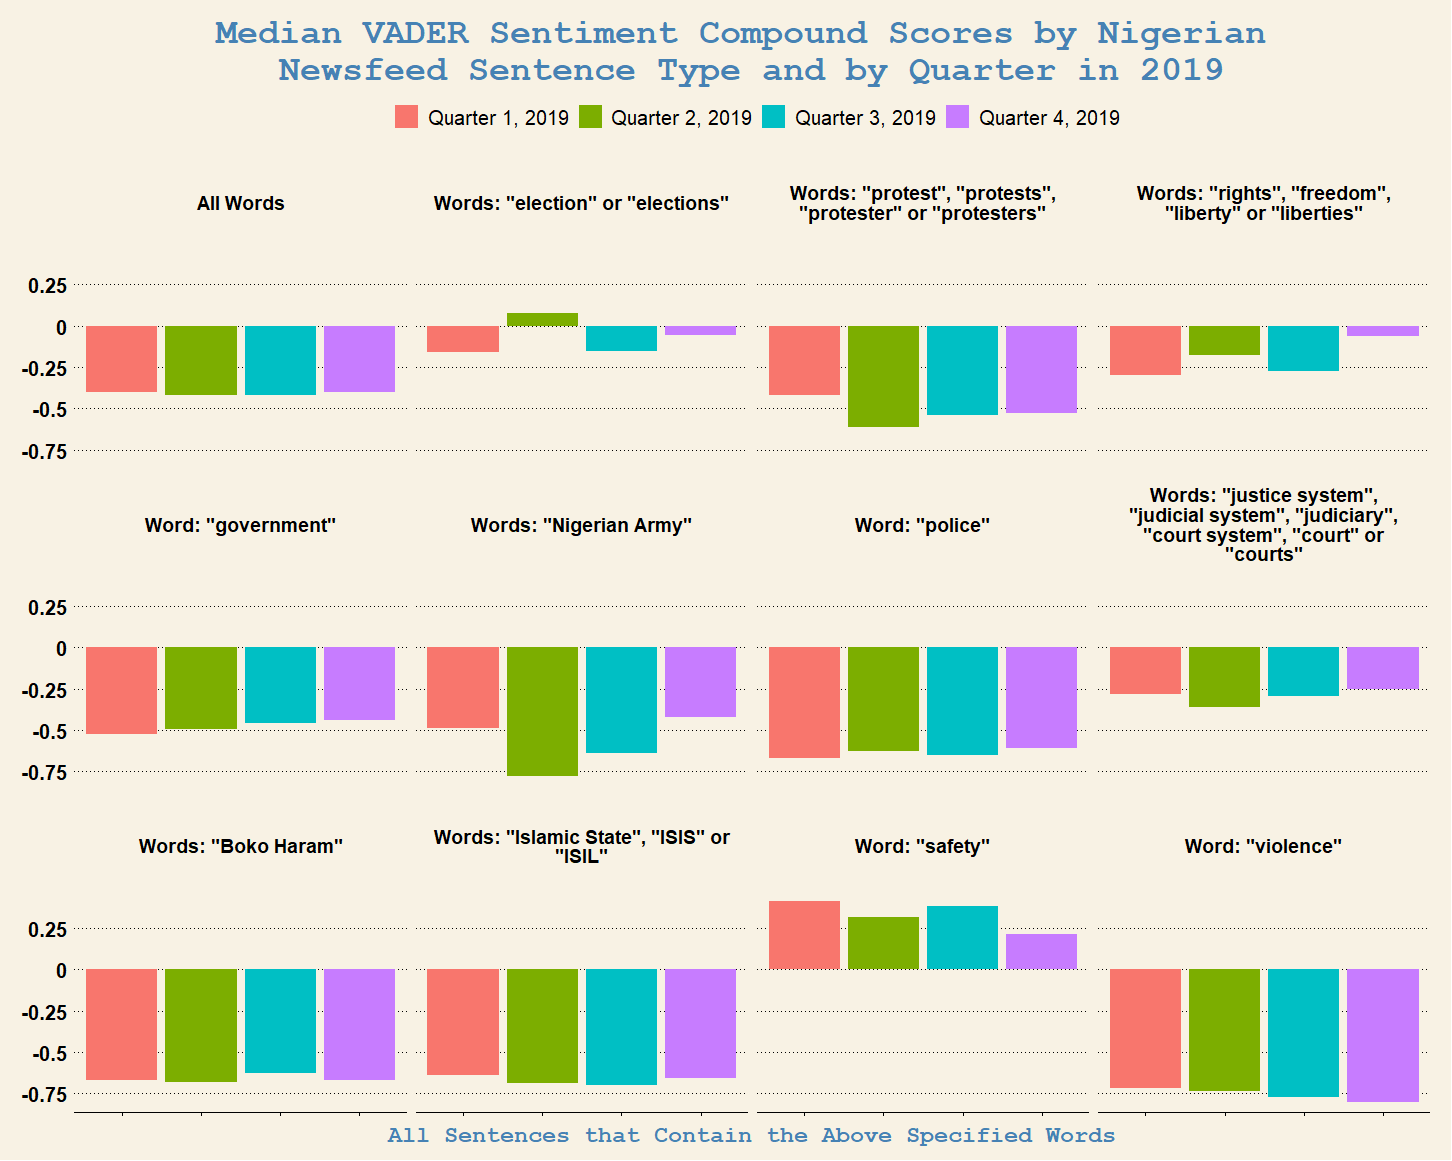

### **Analysis:**

### As shown in the visualization above, the VADER sentiment compound scores, which in theory can range between -1 and 1, are mostly negative among sentences in the news articles on Nigeria for 2019, regardless of quarter. When considering all sentences (except those discarded for having a compound score of 0.0000) the median score in all 4 quarters of 2019 is less than -0.4. Thus, the scores of sentences having "All Words" (i.e., not restricting analysis to sentences with any particular words) can be seen as a baseline with which to compare all other sampled categories of sentences from this dataset.

### VADER compound scores for sentences having the words "election" or "elections" have scores far better than the baseline of ~ -0.4, with the second quarter score reaching positive levels for this sentence category. Sentences having the words "rights, "freedom", "liberty" or "liberties" were also better than the baseline scores, as were sentences having the words "justice system", "judicial system", "judiciary", "court system", "court", or "courts", and sentences containing the word "safety." This latter category of sentences was the only one to contain *positive* VADER compound scores across all 2019 quarters.

### Sentence categories containing the word "police", containing the words "Boko Haram", containing the words "Islamic State", "ISIS", or "ISIL", and containing the word "violence" all had very negative VADER compound scores compared to baseline. It is noteworthy that although in quarter 1 of 2019 sentences containing the words "Nigerian Army" start with a VADER compound score higher than baseline, in the second quarter this sentence category substantially dropped lower than baseline before gradually improving in quarter 3 (still below baseline) and in quarter 4 (climbing about even with baseline). There may have been events in the news during the second and third quarters of 2019 in particular which led to lower than normal levels of sentiment regarding the Nigerian Army.

### It is also noteworthy that there appear to be slightly fluctuating trends in sentiment across all quarters (although clearly still higher in value than baseline) with regards to sentences containing the words "election" or "elections", sentences containing the words "rights", "freedom", "liberty", or "liberties", and sentences containing the word "safety".